In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt # For data viz
import numpy as np
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)

IMAGE_DIRECTORY = 'images'
TRAIN_SIZE = 0.8
SEED = 5111997
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 20
torch.manual_seed(SEED)

System Version: 3.10.14 | packaged by Anaconda, Inc. | (main, May  6 2024, 19:44:50) [MSC v.1916 64 bit (AMD64)]
PyTorch version 2.3.1
Torchvision version 0.18.1
Numpy version 1.24.3


In [33]:
#Creating the class for the dataset
class PositionDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
        pass

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [40]:
#Creating the classifier
class PositionClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(PositionClassifier, self).__init__()
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True, in_chans=1)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        self.classifier = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.features(x)
        output = self.classifier(x)
        return output


In [49]:
#Loading in dataset and converting dataset to tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    # transforms.Grayscale(1)
])

full_dataset = PositionDataset(IMAGE_DIRECTORY, transform)
train_dataset, validation_dataset = torch.utils.data.random_split(full_dataset, [TRAIN_SIZE, 1 - TRAIN_SIZE], torch.Generator().manual_seed(SEED))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [50]:
for images, labels in train_loader:
    break

T = transforms.ToPILImage()
x = T(images[0])
x.show()

In [42]:
#Creating the training loop
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
train_losses, validation_losses = [], []
model = PositionClassifier()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(validation_loader, desc='Validation loop'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    validation_loss = running_loss / len(validation_loader.dataset)
    validation_losses.append(validation_loss)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train loss: {train_loss}, Validation loss: {validation_loss}")


Device:  cuda


Training loop:   0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

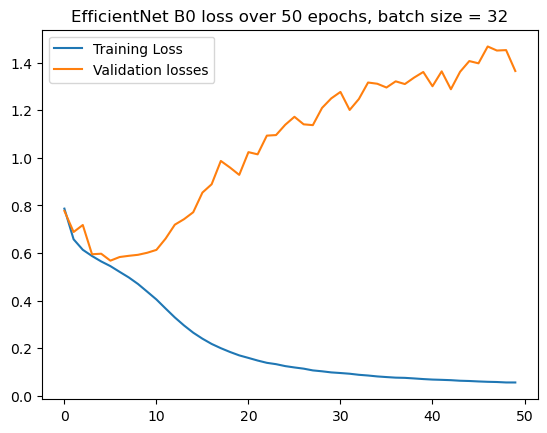

In [30]:
#Graph
plt.plot(train_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation losses")
plt.legend()
plt.title("EfficientNet B0 loss over 50 epochs, batch size = 32")
plt.show()

In [27]:
model_path = f"models/efficientnet_b0_{NUM_EPOCHS}epochs_{BATCH_SIZE}batch.pth"
torch.save(model.state_dict(), model_path)

In [29]:
#testing model accuracy
model_path = f"models/efficientnet_b0_{NUM_EPOCHS}epochs_{BATCH_SIZE}batch.pth"
model = PositionClassifier()
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()
num_correct = 0
with torch.no_grad():
    for images, labels in tqdm(train_loader, desc='Validation loop'):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        for i in range(len(outputs)):
            if torch.argmax(outputs[i]) == labels[i]:
                num_correct += 1
print(num_correct / len(train_dataset))


Validation loop:   0%|          | 0/5000 [00:00<?, ?it/s]

0.9909059089715865
